Using device: cuda:0


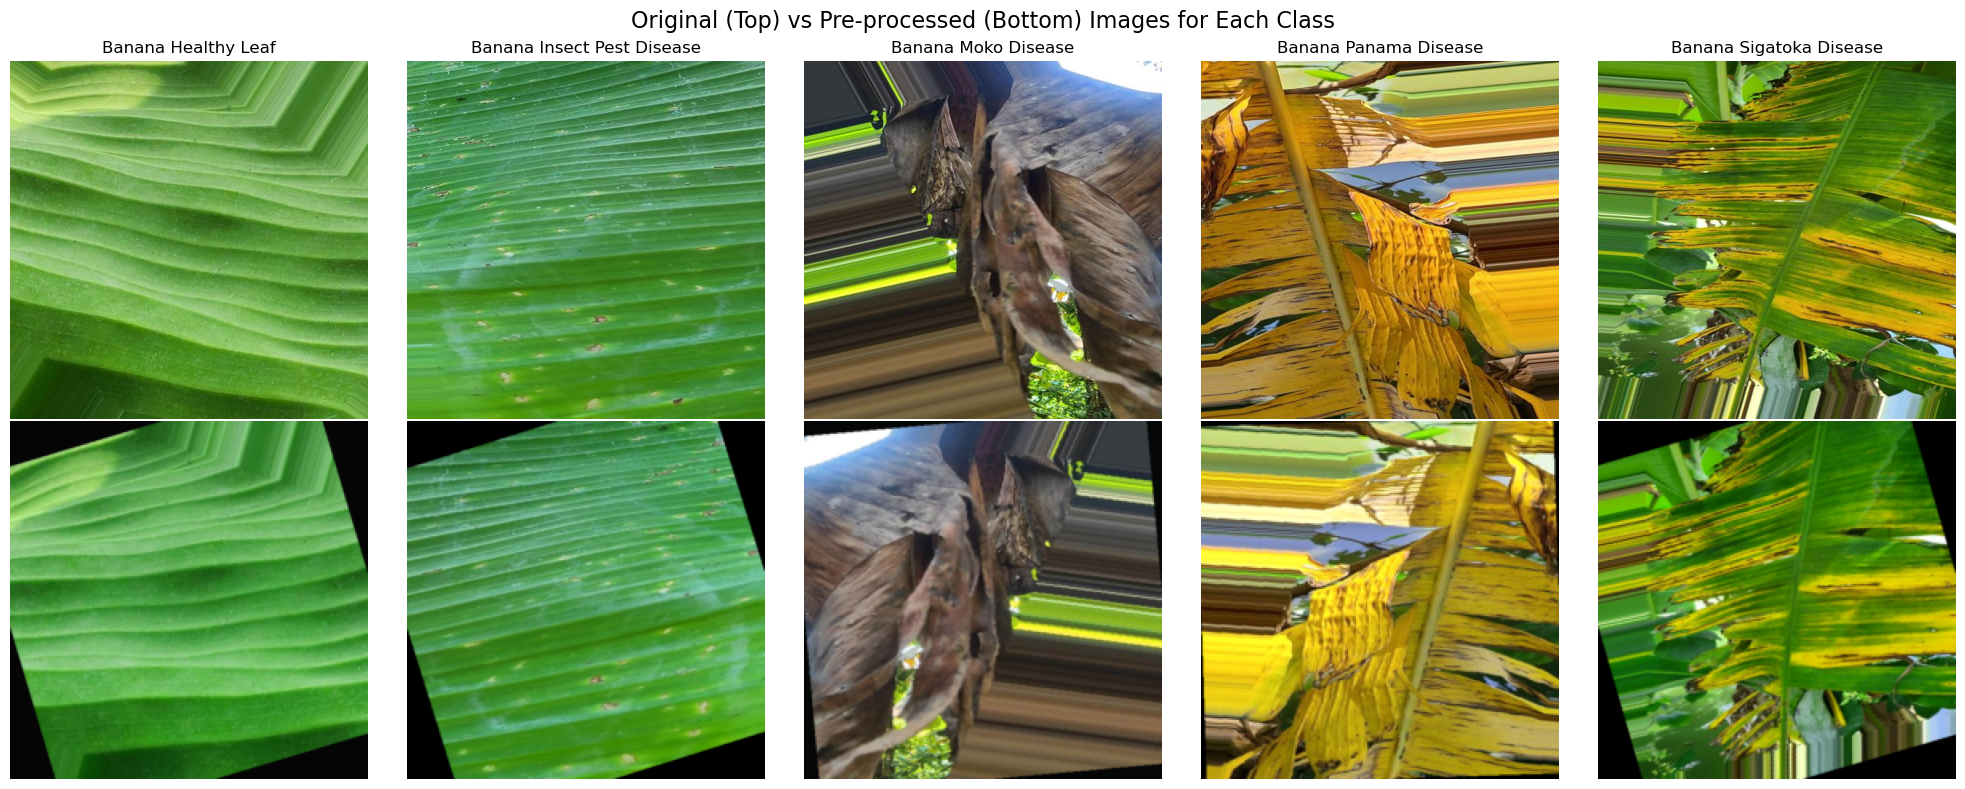

Resuming from checkpoint: C:\Users\syhaw\Downloads\Conference\Resume_Training\RT_BDD_CNN_ResNet50.pth
Epoch 9/10 | TLoss: 0.0084  TAcc: 99.86% | VLoss: 0.0004  VAcc: 100.00% | LR: 1.00e-03
 Epoch time: 180.5s

Epoch 10/10 | TLoss: 0.0537  TAcc: 92.77% | VLoss: 0.5293  VAcc: 94.12% | LR: 1.00e-03
 Epoch time: 193.9s

Done in 0h 31m 19s. Best VAcc: 100.00%



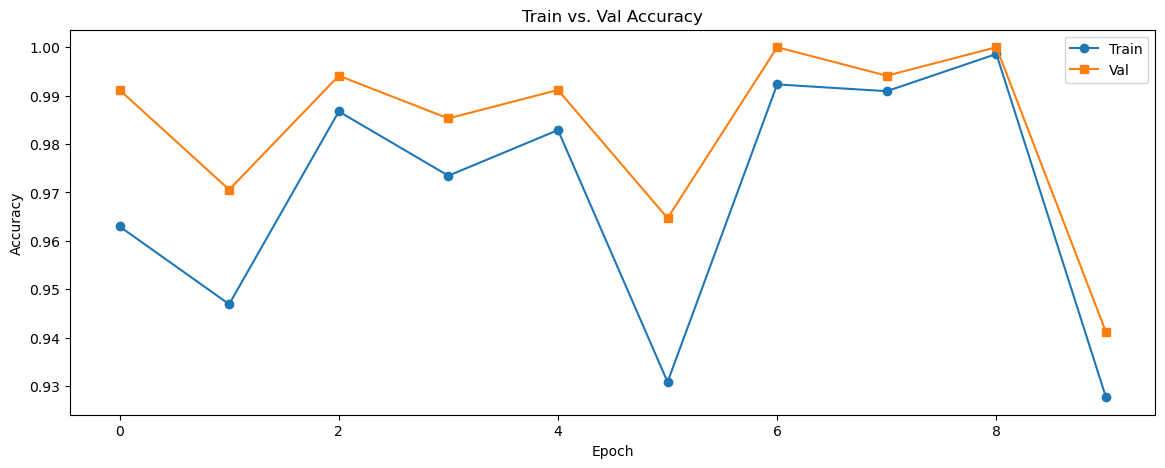

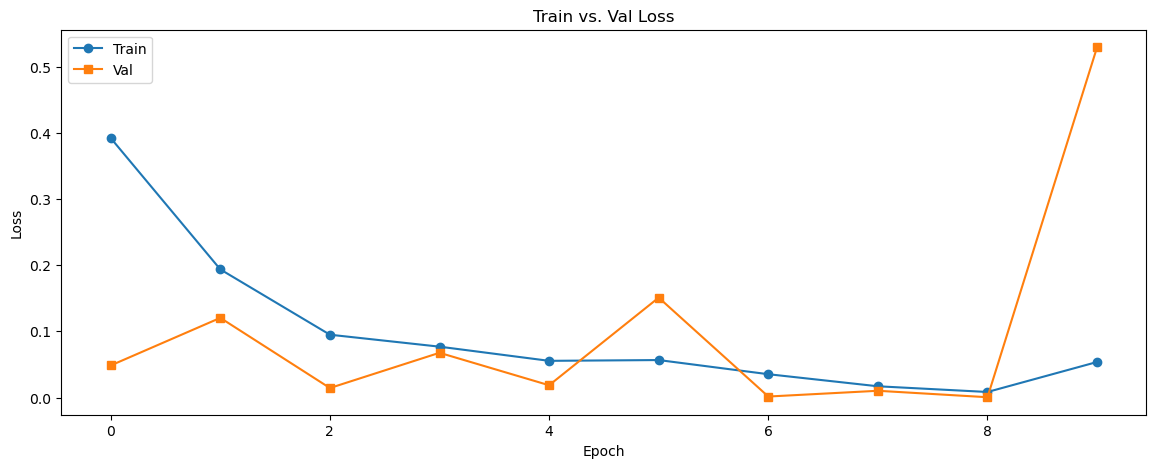

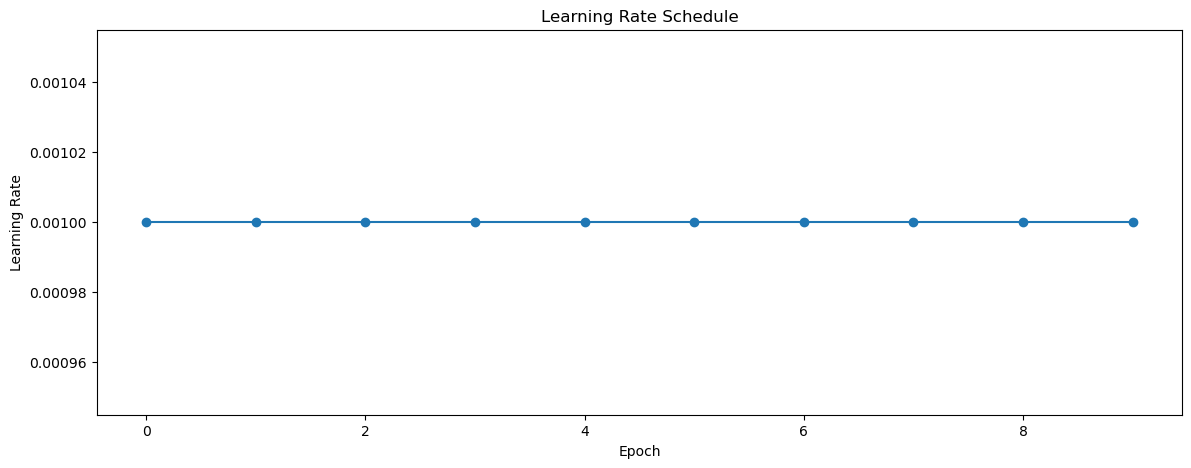

Best Confusion Matrix:


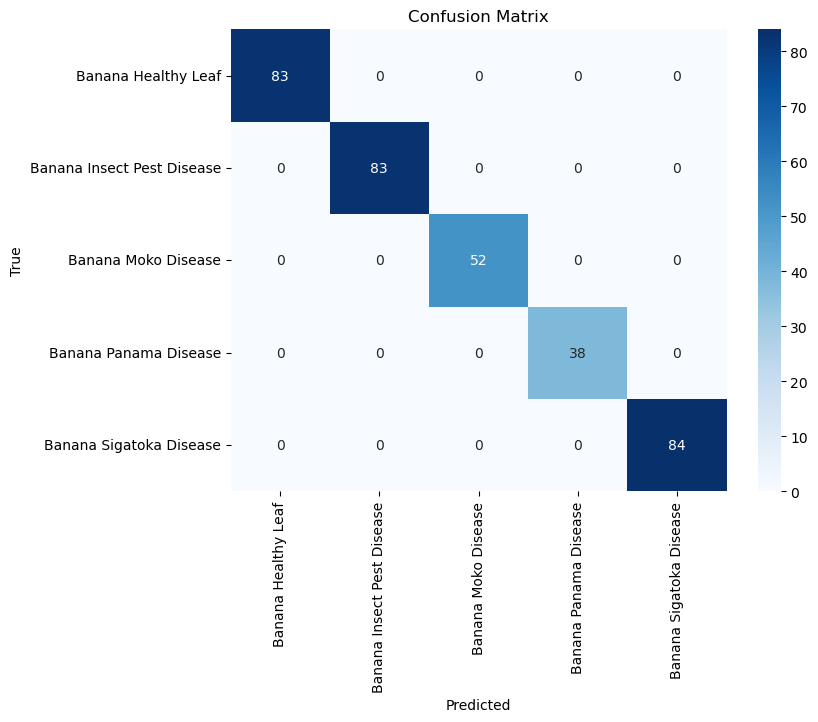

Loading best model weights for final evaluation...

=== Overall Performance ===
Accuracy : 100.00%
Precision: 100.00%
Recall   : 100.00%
F1-Score : 100.00%



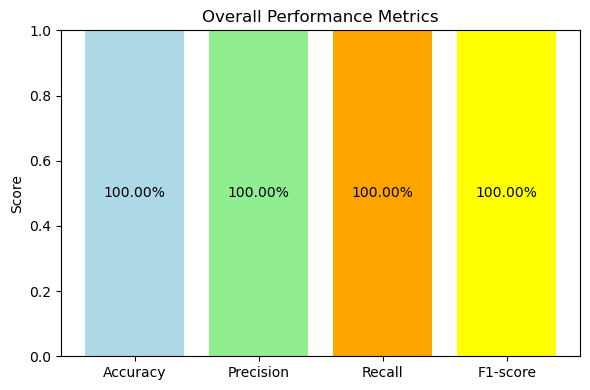

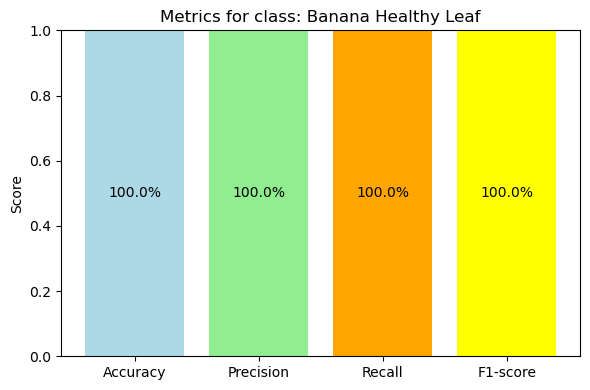

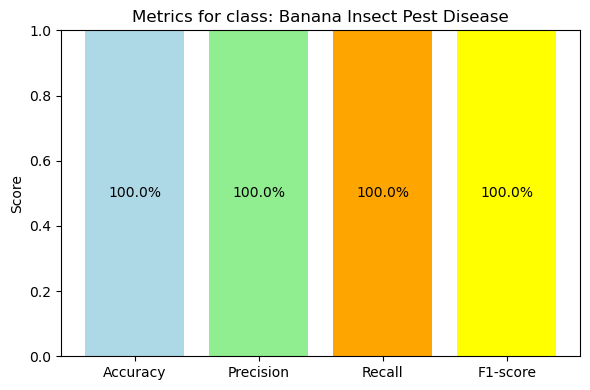

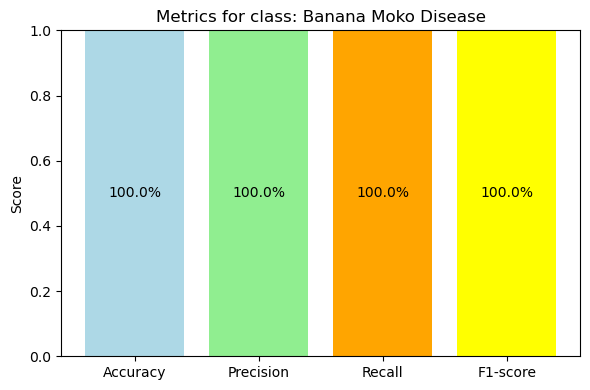

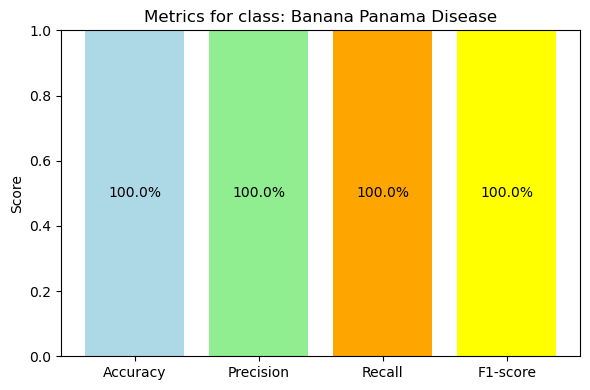

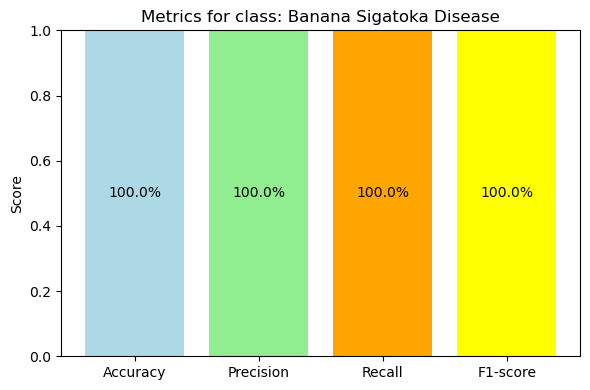

In [6]:
import os
import time
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from torch.amp import GradScaler, autocast

# === Paths Configuration ===
train_dir       = r"G:\Mega_Project\Dataset\5_Classes\Kaggle_Combined_5_Classes"
val_dir         = r"G:\Mega_Project\Dataset\5_Classes\Kaggle_OG_5_Classes"
checkpoint_path = r"C:\Users\syhaw\Downloads\Conference\Resume_Training\RT_BDD_CNN_ResNet50.pth"

# === Device & Seed ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === Dataset with CLAHE ===
class BananaDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self._apply_clahe(img)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

    def _apply_clahe(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl,a,b))
        return cv2.cvtColor(merged, cv2.COLOR_Lab2RGB)

# === Transforms ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# === Helpers ===
def load_dataset(folder):
    paths, labels = [], []
    classes = sorted(d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)))
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder, cls)
        for f in os.listdir(cls_folder):
            if f.lower().endswith(('png','jpg','jpeg')):
                paths.append(os.path.join(cls_folder, f))
                labels.append(idx)
    return paths, labels, classes

def compute_train_accuracy(model, loader):
    model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
            _, p = torch.max(out, 1)
            preds += p.cpu().tolist()
            labs  += y.cpu().tolist()
    model.train()
    return accuracy_score(labs, preds)

def validate_model(model, loader, criterion):
    model.eval()
    preds, labs = [], []
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            loss_sum += loss.item()
            _, p = torch.max(out, 1)
            preds += p.cpu().tolist()
            labs  += y.cpu().tolist()
    cm  = confusion_matrix(labs, preds)
    acc = accuracy_score(labs, preds)
    model.train()
    return acc, (loss_sum/len(loader)), cm, preds, labs

def plot_curve(train_vals, val_vals, ylabel, title):
    plt.figure(figsize=(14,5))
    plt.plot(train_vals, marker='o')
    plt.plot(val_vals, marker='s')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(['Train','Val'])
    plt.show()

def plot_lr_curve(lrs):
    plt.figure(figsize=(14,5))
    plt.plot(lrs, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

def plot_confusion(cm, labels, cmap='Blues'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_class_metrics(idx, class_name, acc_arr, prec_arr, rec_arr, f1_arr):
    metrics = ['Accuracy','Precision','Recall','F1-score']
    values  = [acc_arr[idx], prec_arr[idx], rec_arr[idx], f1_arr[idx]]
    colors = ['lightblue', 'lightgreen', 'orange', 'yellow']  # Custom color mapping

    plt.figure(figsize=(6,4))
    bars = plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1.0)
    plt.title(f"Metrics for class: {class_name}")
    plt.ylabel("Score")

    for bar, val in zip(bars, values):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h * 0.5,
                 f"{h * 100:.1f}%", ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
def display_original_and_preprocessed_images(image_paths, labels, transform, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(2, num_classes, figsize=(4*num_classes, 8))
    fig.suptitle("Original (Top) vs Pre-processed (Bottom) Images for Each Class", fontsize=16)
    for i, class_name in enumerate(class_names):
        idx = next((j for j, lbl in enumerate(labels) if lbl == i), None)
        if idx is None: continue
        orig = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(orig)
        axes[0, i].set_title(class_name)
        axes[0, i].axis('off')
        proc = transform(orig.copy()).permute(1,2,0).numpy()
        proc = proc * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        proc = np.clip(proc, 0, 1)
        axes[1, i].imshow(proc)
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_overall_metrics(acc, prec, rec, f1):
    metrics = ['Accuracy','Precision','Recall','F1-score']
    values = [acc, prec, rec, f1]
    colors = ['lightblue', 'lightgreen', 'orange', 'yellow']   # Custom color mapping

    plt.figure(figsize=(6,4))
    bars = plt.bar(metrics, values, color=colors)
    plt.ylim(0, 1.0)
    plt.title('Overall Performance Metrics')
    plt.ylabel('Score')

    for bar, val in zip(bars, values):
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 h * 0.5,
                 f"{h * 100:.2f}%",
                 ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# === Main ===
def main():
    # --- Data ---
    train_paths, train_labels, class_names = load_dataset(train_dir)
    val_paths,   val_labels,   _           = load_dataset(val_dir)

    display_original_and_preprocessed_images(
        train_paths, train_labels, train_transform, class_names
    )

    train_loader = DataLoader(
        BananaDiseaseDataset(train_paths, train_labels, train_transform),
        batch_size=32, shuffle=True
    )
    val_loader   = DataLoader(
        BananaDiseaseDataset(val_paths,   val_labels,   val_transform),
        batch_size=32, shuffle=False
    )

    # --- Model Setup ---
    cw = compute_class_weight('balanced',
                              classes=np.unique(train_labels),
                              y=train_labels)
    cw = torch.tensor(cw, dtype=torch.float).to(device)

    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_f, len(class_names))
    )
    for p in model.parameters(): p.requires_grad = False
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True
    for p in model.fc.parameters():    p.requires_grad = True
    model.to(device)

    criterion = nn.CrossEntropyLoss(weight=cw)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=3
    )
    scaler = GradScaler()

    # --- Resume State ---
    start_epoch     = 0
    best_accuracy   = 0.0
    best_cm         = None
    best_wts        = None
    all_train_accs  = []
    all_val_accs    = []
    all_train_losses= []
    all_val_losses  = []
    all_lrs         = []
    epoch_durations = []
    total_elapsed   = 0.0

    if os.path.isfile(checkpoint_path):
        print(f"Resuming from checkpoint: {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer_state'])
        scheduler.load_state_dict(ckpt['scheduler_state'])
        scaler.load_state_dict(ckpt['scaler_state'])
        start_epoch      = ckpt['epoch'] + 1
        best_accuracy    = ckpt['best_accuracy']
        best_cm          = ckpt['best_cm']
        best_wts         = ckpt['best_wts']
        all_train_accs   = ckpt['train_accs']
        all_val_accs     = ckpt['val_accs']
        all_train_losses = ckpt['train_losses']
        all_val_losses   = ckpt['val_losses']
        all_lrs          = ckpt['lrs']
        total_elapsed    = ckpt.get('total_elapsed', 0.0)

    # --- Training Loop ---
    num_epochs = 10
    for epoch in range(start_epoch, num_epochs):
        t0 = time.time()
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc  = compute_train_accuracy(model, train_loader)
        all_train_losses.append(train_loss)
        all_train_accs.append(train_acc)
        lr = optimizer.param_groups[0]['lr']
        all_lrs.append(lr)

        val_acc, val_loss, cm, _, _ = validate_model(model, val_loader, criterion)
        all_val_losses.append(val_loss)
        all_val_accs.append(val_acc)

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"TLoss: {train_loss:.4f}  TAcc: {train_acc*100:.2f}% | "
            f"VLoss: {val_loss:.4f}  VAcc: {val_acc*100:.2f}% | "
            f"LR: {lr:.2e}"
        )

        scheduler.step(val_acc)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_cm       = cm
            best_wts      = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - t0
        epoch_durations.append(epoch_time)
        total_elapsed += epoch_time

        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state': scaler.state_dict(),
            'best_accuracy': best_accuracy,
            'best_cm': best_cm,
            'best_wts': best_wts,
            'train_accs': all_train_accs,
            'val_accs': all_val_accs,
            'train_losses': all_train_losses,
            'val_losses': all_val_losses,
            'lrs': all_lrs,
            'total_elapsed': total_elapsed
        }, checkpoint_path)

        print(f" Epoch time: {epoch_time:.1f}s\n")

    # --- Post-Training Diagnostics ---
    h, rem = divmod(total_elapsed, 3600)
    m, s   = divmod(rem, 60)
    print(f"Done in {int(h)}h {int(m)}m {int(s)}s. Best VAcc: {best_accuracy*100:.2f}%\n")

    plot_curve(all_train_accs, all_val_accs, 'Accuracy', 'Train vs. Val Accuracy')
    plot_curve(all_train_losses, all_val_losses, 'Loss', 'Train vs. Val Loss')
    plot_lr_curve(all_lrs)

    print("Best Confusion Matrix:")
    plot_confusion(best_cm, class_names, cmap='Blues')

    print("Loading best model weights for final evaluation...")
    model.load_state_dict(best_wts)
    model.eval()
    _, _, _, final_preds, final_labs = validate_model(model, val_loader, criterion)

    o_acc  = accuracy_score(final_labs, final_preds)
    o_prec = precision_score(final_labs, final_preds, average='weighted')
    o_rec  = recall_score(final_labs, final_preds, average='weighted')
    o_f1   = f1_score(final_labs, final_preds, average='weighted')

    print("\n=== Overall Performance ===")
    print(f"Accuracy : {o_acc*100:.2f}%")
    print(f"Precision: {o_prec*100:.2f}%")
    print(f"Recall   : {o_rec*100:.2f}%")
    print(f"F1-Score : {o_f1*100:.2f}%\n")

    plot_overall_metrics(o_acc, o_prec, o_rec, o_f1)

    per_prec = precision_score(final_labs, final_preds, average=None)
    per_rec  = recall_score(final_labs, final_preds, average=None)
    per_f1   = f1_score(final_labs, final_preds, average=None)
    per_acc  = best_cm.diagonal() / best_cm.sum(axis=1)

    for idx, cls in enumerate(class_names):
        plot_class_metrics(idx, cls, per_acc, per_prec, per_rec, per_f1)

if __name__ == '__main__':
    main()
